In [1]:
!mkdir -p ~/.Kaggle
!cp kaggle.json ~/.Kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:49<00:00, 23.4MB/s]
100% 1.06G/1.06G [00:49<00:00, 23.0MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = r'/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = r'/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [6]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.05),
    layers.RandomRotation(0.05)
])

In [7]:
def prepare_data(images, labels):
  augmented_images = data_augmentation(images, training = True)
  return augmented_images, labels

In [8]:
train_ds_augmented = train_ds.map(
    prepare_data,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [9]:
mix_ds = train_ds.concatenate(train_ds_augmented)

In [10]:
def pre_processing(image, label):
  image = tf.cast(image/255. , tf.float32)
  return image, label

mix_ds = mix_ds.map(pre_processing)
validation_ds = validation_ds.map(pre_processing)

In [11]:
from tensorflow.keras.applications import VGG16

In [12]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (256,256,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [13]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.96,
)

In [16]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=3,
    verbose=1,
    mode="auto",
    restore_best_weights=True
)

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation


In [34]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate= 0.001), loss = ['binary_crossentropy'],metrics =['accuracy'])


In [35]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.96,
)

In [25]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=3,
    verbose=1,
    mode="auto",
    restore_best_weights=True
)

In [36]:
from tensorflow.keras.callbacks import Callback

conv_base.trainable = False
class UnfreezeCallback(Callback):
  def unfreeze_training(self,epoch,logs=None):
    if epoch == 3:
      conv_base.trainable = True
      set_trainable = False
      for layer in conv_base.layers:
        if layer == 'block5_conv1':
          set_trainable = True
          if set_trainable:
            layer.trainable = True
        else:
          layer.trainable = False

      self.model.compile(optimizer=Adam(learning_rate = lr), loss = ['binary_crossentropy'],metrics =['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,138,113 (88.26 MB)

 Trainable params: 8,422,657 (32.13 MB)

 Non-trainable params: 14,715,456 (56.14 MB)

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint("my_model.h5", save_best_only=False, save_weights_only=False)


In [39]:
history = model.fit(mix_ds,validation_data=validation_ds,epochs=15,callbacks=[early_stopping,UnfreezeCallback(),checkpoint_cb])

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.8987 - loss: 0.2375

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 435s 345ms/step - accuracy: 0.8987 - loss: 0.2375 - val_accuracy: 0.9386 - val_loss: 0.1449
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9578 - loss: 0.1061

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 434s 340ms/step - accuracy: 0.9578 - loss: 0.1061 - val_accuracy: 0.9406 - val_loss: 0.1456
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9725 - loss: 0.0740

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 444s 341ms/step - accuracy: 0.9725 - loss: 0.0740 - val_accuracy: 0.9442 - val_loss: 0.1427
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9826 - loss: 0.0493

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 440s 339ms/step - accuracy: 0.9826 - loss: 0.0493 - val_accuracy: 0.9270 - val_loss: 0.2081
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9857 - loss: 0.0422

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 428s 342ms/step - accuracy: 0.9857 - loss: 0.0422 - val_accuracy: 0.9282 - val_loss: 0.2096
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9896 - loss: 0.0308

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 554s 432ms/step - accuracy: 0.9896 - loss: 0.0308 - val_accuracy: 0.9456 - val_loss: 0.1555
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [40]:
import matplotlib.pyplot as plt

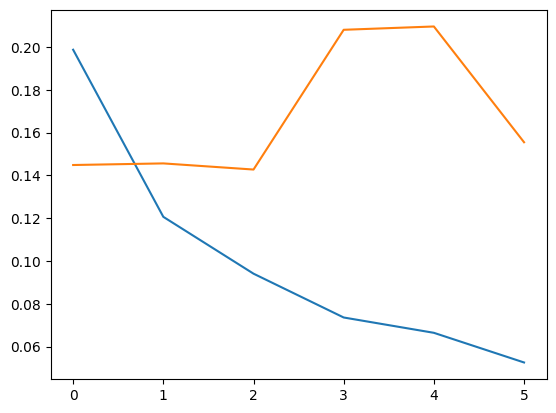

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

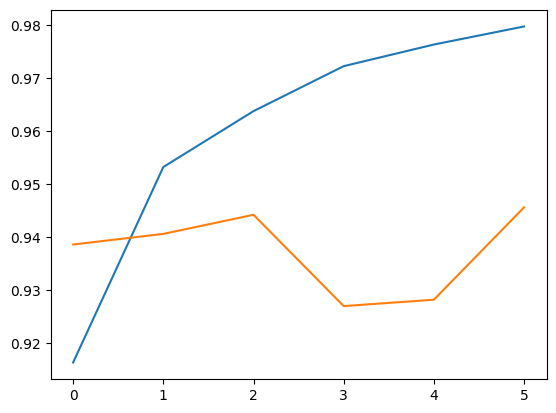

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])